# Customer Care Analytics Assessment - Satya Penmetsa

#### Importing pandas and other libraries

In [1]:
import pandas as pd
import numpy as np
import re                                  
import string  
import math
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import json
from tqdm import tqdm
from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()
import os
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer   
from wordcloud import WordCloud#, STOPWORDS, ImageColorGenerator
pd.options.display.max_columns = None
np.set_printoptions(suppress=True)
pd.options.mode.chained_assignment = None

#### Read the Excel data

Read the "comments" column as a string and replace "NaN" with blank for text mining

In [2]:
samsung_survey_data = pd.read_excel( 'NPS_Case_Study.xlsx',sheet_name='samsungus_responses_export_2020',dtype={'Please tell us the reasons for your scores (comment)':str})

In [3]:
samsung_survey_data.shape

(44893, 50)

In [4]:
samsung_survey_data.head()

,Account Name,Survey ID,Invitation date,Response Date,Product Line,Service Date,Material Group,Service Type,Region,Technician ID,ASC Account,Major Accounts,Defect,Symptom Category 1 Desc,Symptom Category 2 Desc,Symptom Category 3 Desc,TAT (Days),Likelihood to recommend (0 - 10),Overall Satisfaction (1 - 7),Overall Satisfaction (0 - 100),Please tell us the reasons for your scores (comment),Requesting the service,Requesting the service (0-100),Scheduling your appointment,Scheduling your appointment (0 - 100),Service was completed in a timely manner,Service was completed in a timely manner (0-100),Issue was resolved to your satisfaction,Issue was resolved to your satisfaction (0-100),Satisfaction with service provider,Technician Timeliness,Technician Timeliness (0-100),Technician Professionalism,Technician Professionalism (0-100),Technician Expertise,Technician Expertise (0-100),Technician Work Quality,Technician Work Quality (0-100),Technician Communication,Technician Communication (0-100),Easy to resolve service issue,Easy to resolve service issue (0-100),Was your issue resolved? (Yes / No),Visit Times,Trip Times,Ship Times,Survey Method Completion,Promoter,Detractor,Neutral
0,RSI [ 0001773863 ],12302909,2020-09-11 09:16:13,2020-09-15 17:14:56,HHP,2020-09-07,Mobile Communication,PS,CA,T4934,1773863,RSI,Other,CALL QUALITY /SOUND,Sound Problems,Low volume/ No sound response,3.0,10.0,7.0,100.00,The experience was great. The technician worke...,7.0,100.00,7.0,100.00,7.0,100.00,7.0,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,100.00,Yes,NaN,NaN,Once,Email,1.0,0.0,0.0
1,RSI [ 0001773863 ],12369739,2020-09-14 21:16:30,2020-09-15 17:14:44,HHP,2020-09-10,CELLULAR PHONE,PS,MA,5386014061,1773863,RSI,Power,Power,Power,No Power After Upgrade,1.0,8.0,7.0,100.00,"While the service was excellent, the problem i...",6.0,83.33,NaN,NaN,7.0,100.00,7.0,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,100.00,Yes,NaN,NaN,Once,Email,0.0,0.0,1.0
2,RSI [ 0001773863 ],12370844,2020-09-14 21:16:37,2020-09-15 17:12:24,HHP,2020-09-11,Module Watch-Type,PS,WA,5386014065,1773863,RSI,Battery,Power,Power,No Power After Upgrade,0.0,10.0,7.0,100.00,From phone call to discuss my issue to receivi...,7.0,100.00,7.0,100.00,7.0,100.00,7.0,100.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,100.00,Yes,NaN,NaN,Once,Email,1.0,0.0,0.0
3,SERVICE QUICK CSP [ BFSCC01 ],12281031,2020-09-11 09:04:02,2020-09-15 17:11:29,WG,2020-09-10,REFRIGERATOR,IH,CA,JATUA02147276,BFSCC01,SERVICE QUICK CSP,No Ice,Ice/Water/Sparkling,Ice making/ice bucket stuck issue,Ice room or bucket frost,5.0,10.0,7.0,100.00,NaN,7.0,100.00,7.0,100.00,7.0,100.00,7.0,100.00,7.0,7.0,100.0,7.0,100.0,7.0,100.0,7.0,100.0,7.0,100.0,7.0,100.00,Yes,Once,NaN,NaN,Email,1.0,0.0,0.0
4,THE REPAIR PROS [ BFSC555 ],12356552,NaT,2020-09-15 17:03:00,WG,2020-09-14,REFRIGERATOR,IH,UT,WATSA12065325,BFSC838,The Repair Pros,NaN,Ice/Water/Sparkling,Leak/dripping,from dispenser,14.0,9.0,6.0,83.33,Jason did a great job!,6.0,83.33,6.0,83.33,6.0,83.33,6.0,83.33,7.0,7.0,100.0,7.0,100.0,7.0,100.0,7.0,100.0,7.0,100.0,6.0,83.33,Yes,Once,NaN,NaN,SMS,1.0,0.0,0.0


In [5]:
samsung_survey_data = samsung_survey_data.replace(np.nan, '', regex=True)

#### Build a word cloud based on the 'comments' field

In [6]:
comments_all = samsung_survey_data["Please tell us the reasons for your scores (comment)"]

In [7]:
comments_all

0        The experience was great. The technician worke...
1        While the service was excellent, the problem i...
2        From phone call to discuss my issue to receivi...
3                                                         
4                                   Jason did a great job!
5        To send back my watch was quick and very good ...
6                         It was easy from start to finish
7        I called Samsung and  was questioning the nois...
8        My device was returned with a statement that t...
9        Scheduled me was easy. The repair company comm...
10       Scheduling on the site was problematic. It wou...
11       I have had kinds of problems with this refrige...
12       The tech fixed everything that needed to be fi...
13       Tech was early, professional,  and he fixed pr...
14       Very pleasant experience. Installers were very...
15       Best Buy wouldn't help with issue and told us ...
16                                                      

Lets do a little bit of preprocessing to get to the relevant material from all the comments

 - Tokenize the words
 - Remove stopwords
 - Remove punctuation

In [8]:
# instantiate tokenizer class; converts all into lower case, removes handles, removes blank spaces
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True,
                               reduce_len=True)
# tokenize comments
comments_all = comments_all.apply(tokenizer.tokenize)

stopwords_english = stopwords.words('english') 

comments_all = comments_all.apply(lambda x:[item for item in x if item not in stopwords_english])
comments_all = comments_all.apply(lambda x:[item for item in x if item not in string.punctuation])

In [9]:
comments_all

0        [experience, great, technician, worked, troubl...
1        [service, excellent, problem, needed, seviced,...
2        [phone, call, discuss, issue, receiving, watch...
3                                                       []
4                                      [jason, great, job]
5        [send, back, watch, quick, good, service, rece...
6                                    [easy, start, finish]
7        [called, samsung, questioning, noise, cancelli...
8        [device, returned, statement, nothing, wrong, ...
9        [scheduled, easy, repair, company, communicate...
10       [scheduling, site, problematic, even, allow, p...
11       [kinds, problems, refrigerator, cooling, right...
12       [tech, fixed, everything, needed, fixed, short...
13       [tech, early, professional, fixed, problem, ri...
14       [pleasant, experience, installers, respectful,...
15       [best, buy, help, issue, told, us, go, online,...
16                                                      

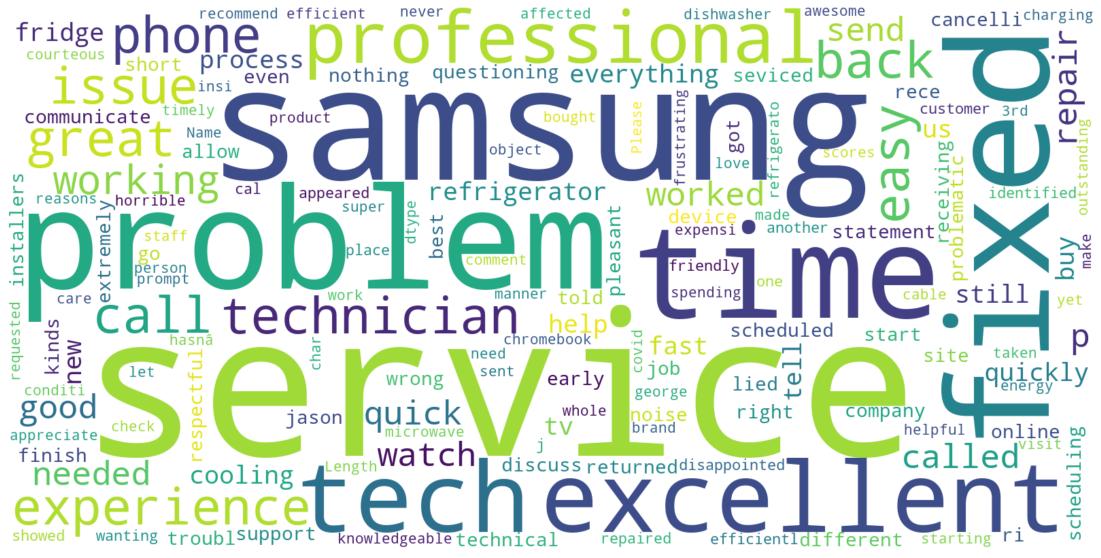

In [10]:
wordcloud1 = WordCloud(width=1600,height=800,background_color="white").generate(str(comments_all))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud1, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Refrigerator specific word cloud

In [11]:
comments_refrig = samsung_survey_data[(samsung_survey_data['Product Line'] == 'WG') & (samsung_survey_data['Material Group'] == 'REFRIGERATOR')]["Please tell us the reasons for your scores (comment)"]

In [12]:
comments_refrig.shape

(14305,)

In [13]:
comments_refrig = comments_refrig.apply(tokenizer.tokenize)

# Adding new stop words
newStopWords = ['samsung','customer','issue','service','problem','great','professional','technician','knowledgeable','refrigerator','tech', 'repair','product','still']
stopwords_english.extend(newStopWords)

comments_refrig = comments_refrig.apply(lambda x:[item for item in x if item not in stopwords_english])
comments_refrig = comments_refrig.apply(lambda x:[item for item in x if item not in string.punctuation])

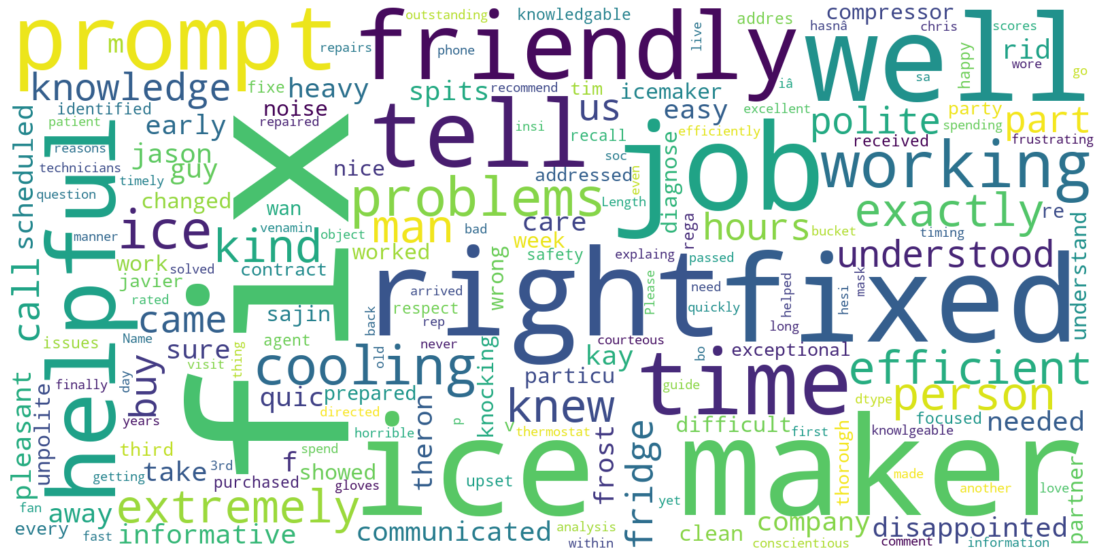

In [14]:
wordcloud2 = WordCloud(width=1600,height=800,background_color="white").generate(str(comments_refrig))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()